## 1. Import packages

In [24]:
## 1.find pressure kick of bottom
## kick은 annulus에 위치해 있음 따라서 애눌러스의 부피 부분을 구하고 킥의 부피를 가정하면 kick의 depth를 구한다
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from math import log, nan

from subfunctions import *

## 1번 반복하는 것 자체를 다시 반복하기
## 전체 코드 수정 
## 이름 naming, 악취나는 code 검사하기

## 2. my all inputs

In [25]:
depth = 10000 ##in ft 
m_rho = 14 ## in ppg
pipe_ID = 4.25 ## inch
pipe_OD = 5 ## inch
casing_ID = 10.75 ## inch 6000ft까지 casing
openhole = 9.5 ## inch
volume = 30  ## bbl 30 bbl 들어왔다고 가정
molar_mass = 16.043 ## g*mol^(-1)
mass =  1428.03145 ## kg
n = mass / molar_mass
R = 8.314 ## J/mol*k = Pa * m^3 / mol * K
T = 298.15 ## K, 섭씨 25도
z = 1
volume_initial = 0.01
mu_p = 16 # in cp 
tau_y = 8 # in lbf/100ft^2
d = 4.25  # in inches
q = 300 # in gpm
roughness = 0.000175 * 100 / 2.54 
rel_roughness = roughness / d
bhp = 7543 ##psi
sicp = 653.56


## 3. Compute #1

In [26]:
ID_c = inside_capacity(openhole, pipe_OD)
f_depth_between = find_depth_between(ID_c, volume)
kick_height_from_bh = 0
P_k_b = Pressure_kick_bottom(kick_height_from_bh, bhp, m_rho)

p_k_z = pressure_kick_z(volume, z, n, R, T)
k_rho = compute_gas_density(z, R, T, molar_mass, p_k_z)
P_hy_bw = P_hy_between(k_rho, f_depth_between)
P_k_m_r = P_kick_middle_r(P_k_b, P_hy_bw) 

vel = velocity(q, openhole, pipe_OD)
mu_a = apparent_viscosity(vel, openhole, pipe_OD, tau_y, mu_p)
Re = reynolds(m_rho, vel, openhole, pipe_OD, mu_a)

if Re > 4000:
    f = friction_factor(Re, rel_roughness)
    dP_per_dL = pressure_gradient_turbulent(f,m_rho, vel, openhole, pipe_OD)
elif Re < 2100:
    dP_per_dL = pressure_gradient_laminar(mu_p, tau_y, vel, openhole, pipe_OD)
else:
    assert False, "Again, we cannot solve this task as 2,100 < Re < 4,000"


In [32]:
depth_list = []
Pressure_friction_list = []
pressure_kick_top_new_list = []
ch_pressure2_list = []
kick_volume_list = []

kick_height_from_bh = 0
step = 1

volume = 30
while  depth > kick_height_from_bh:
    
    P_k_b = Pressure_kick_bottom(kick_height_from_bh, bhp, m_rho)
    volume_z = 0
    while abs(volume_z-volume) > 5:
        p_k_z = pressure_kick_z(volume, z, n, R, T)
        k_rho = compute_gas_density(z, R, T, molar_mass, p_k_z)
        P_hy_bw = P_hy_between(k_rho, f_depth_between)
        P_k_m_r = P_kick_middle_r(P_k_b, P_hy_bw)
        volume_z = volume_kick_z(P_k_m_r, z, n, R, T)
        volume += 0.001
    
    v_k_x = volume
    cal_f_depth_between = cal_find_depth_between(ID_c, v_k_x)
    cal_P_hy_bw = cal_P_hy_between(k_rho, cal_f_depth_between)
    cal_P_k_m_r = cal_P_kick_middle_r(P_k_b, cal_P_hy_bw)
    p_k_t = pressure_kick_top(cal_P_k_m_r, cal_P_hy_bw)
    ch_pressure2 = choke_pressure2(p_k_t, m_rho, depth-kick_height_from_bh, dP_per_dL, cal_f_depth_between)
    
    
    depth_list.append(kick_height_from_bh)
    pressure_kick_top_new_list.append(p_k_t)
    ch_pressure2_list.append(ch_pressure2)
    kick_volume_list.append(volume)
    kick_height_from_bh += step

df_before_exit = pd.DataFrame({'depth': depth_list, 
                               'choke_pressure': ch_pressure2_list, 
                               'k_top_pressure':pressure_kick_top_new_list,
                               'kick_volume': kick_volume_list})


## 4. Compute #2

In [19]:
# ch_pressure3 = choke_pressure3(p_k_t, m_rho, depth, dP_per_dL, cal_f_depth_between_new)

# step = 0.1
# volume_kick_list = []
# cal_find_depth_between_new_list = []
# choke_pressure3_list = []

# while v_k_x > 0:
#     volume_kick_list.append(v_k_x)
#     cal_find_depth_between_new_list.append(cal_f_depth_between_new)
#     choke_pressure3_list.append(ch_pressure3)
#     cal_f_depth_between_new = cal_find_depth_between(ID_c, v_k_x)
#     v_k_x -= step
#     cal_f_depth_between_new = cal_find_depth_between(ID_c, v_k_x)
#     ch_pressure3 = choke_pressure3(p_k_t, m_rho, depth, dP_per_dL, cal_f_depth_between_new)

# df_after_exit = pd.DataFrame({'volume when kick go surface': volume_kick_list, 'depth of kick': cal_find_depth_between_new_list, 'choke pressure3': choke_pressure3_list})


## Visualization

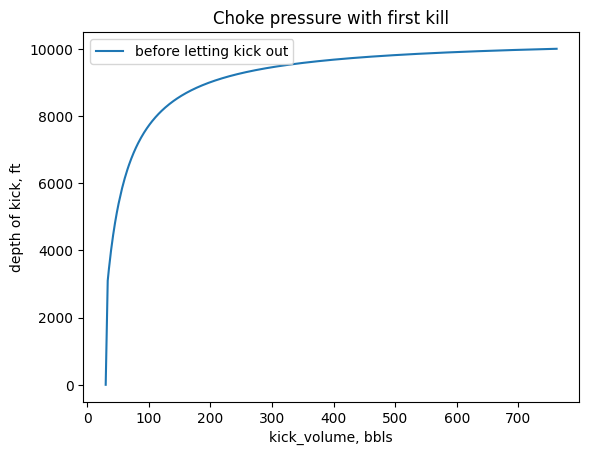

In [20]:
plt.plot(df_before_exit['kick_volume'], df_before_exit['depth'], label = 'before letting kick out')
# plt.plot(df_after_exit['choke pressure3'], df_after_exit['depth of kick'], label = 'after letting kick out')
plt.title('Choke pressure with first kill')
plt.ylabel('depth of kick, ft')
plt.xlabel('kick_volume, bbls')
plt.legend()
plt.show()

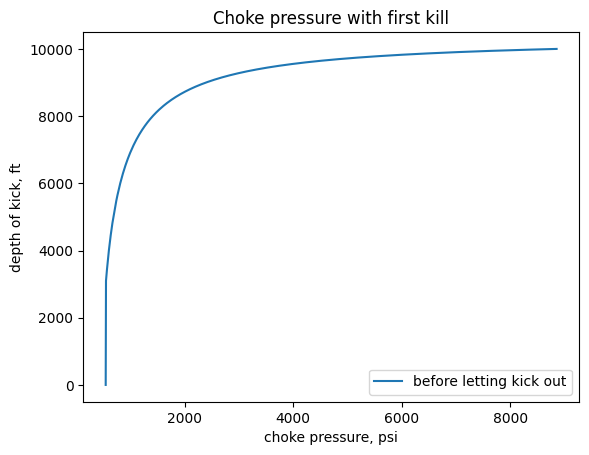

In [21]:
plt.plot(df_before_exit['choke_pressure'], df_before_exit['depth'], label = 'before letting kick out')
# plt.plot(df_after_exit['choke pressure3'], df_after_exit['depth of kick'], label = 'after letting kick out')
plt.title('Choke pressure with first kill')
plt.ylabel('depth of kick, ft')
plt.xlabel('choke pressure, psi')
plt.legend()
plt.show()

In [26]:
df_after_exit.head()

,volume when kick go surface,depth of kick,choke pressure3
0,28.628804,451.655032,7503.602089
1,28.528804,450.077408,7502.453579
2,28.428804,448.499783,7501.305068
3,28.328804,446.922159,7500.156557
4,28.228804,445.344534,7499.008047


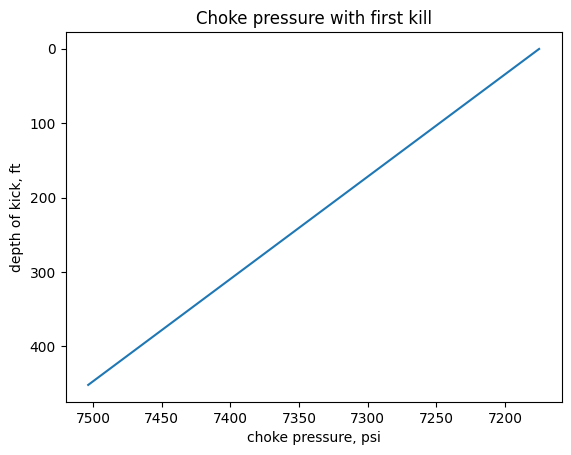

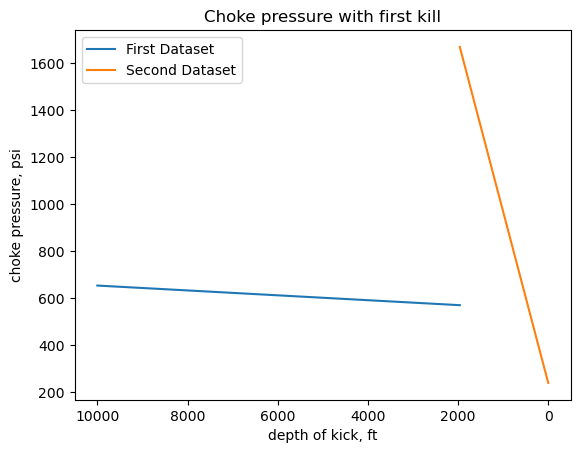

In [ ]:
plt.gca().invert_xaxis()
plt.plot(depth_list, choke_pressure2_list, label='First Dataset')
plt.plot(r_cal_find_depth_between_new_list, choke_pressure3_list, label='Second Dataset')
plt.title('Choke pressure with first kill')
plt.xlabel('depth of kick, ft')
plt.ylabel('choke pressure, psi')
plt.legend()
plt.show()